In [9]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from colorsys import hls_to_rgb

# System parameters

In [2]:
# size of the region of interest
roi_size_px = 332
# wavelength of acquisition
lambda_m = 13.5e-9

# effective pixel size
dx_m = 15e-9
# effective field size
Dx_m = roi_size_px * dx_m

# spatial scales
x_m = np.arange(1, roi_size_px + 1) * dx_m
y_m = np.arange(1, roi_size_px + 1) * dx_m

# angular frequency scale
fs = 1 / (x_m[1] - x_m[0])
Nfft = len(x_m)
df = fs / Nfft
freq_cpm = np.arange(0, fs, df) - (fs - Nfft % 2 * df) / 2

# frequency cut-off of the lens (0.33 4xNA lens)
fc_lens = (np.arcsin(.33/4)/lambda_m)
# lens pupil filter in reciprocal space
Fx, Fy = np.meshgrid(freq_cpm, freq_cpm)
FILTER = (Fx**2 + Fy**2) <= fc_lens**2

# Helper functions

In [3]:
# centered Fourier Transform
ft = lambda signal: np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(signal)))
ift = lambda signal: np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(signal)))

# circular shifting
def circshift2(input, x_shift_px, y_shift_px):
    return np.roll(np.roll(input, round(x_shift_px), axis=1), round(y_shift_px), axis=0)

def colorize(z):
    n,m = z.shape
    c = np.zeros((n,m,3))
    c[np.isinf(z)] = (1.0, 1.0, 1.0)
    c[np.isnan(z)] = (0.5, 0.5, 0.5)

    idx = ~(np.isinf(z) + np.isnan(z))
    A = (np.angle(z[idx]) + np.pi) / (2*np.pi)
    A = (A + 0.5) % 1.0
    B = 1.0 - 1.0/(1.0+abs(z[idx])**0.3)
    c[idx] = [hls_to_rgb(a, b, 0.8) for a,b in zip(A,B)]
    return c


# Create line object with roughness

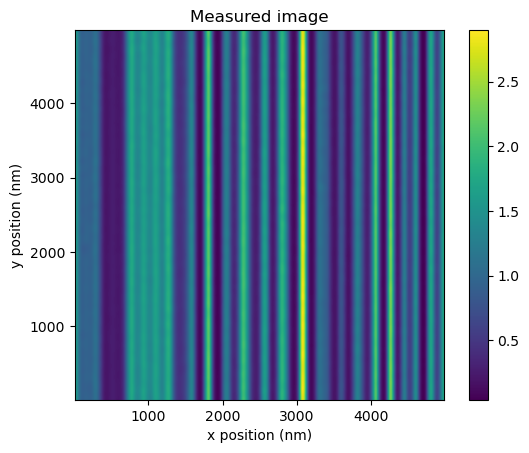

In [4]:
# initialize object
obj = np.ones((roi_size_px, roi_size_px))
roughness_nm = 0.2
obj_rough = obj * np.exp(1j * 2 * np.pi / lambda_m * 2 * roughness_nm * 1e-9 * np.random.randn(roi_size_px, roi_size_px))

# pitch size
p_nm = 4*dx_m*1e9
X_m, Y_m = np.meshgrid(x_m, y_m)
obj_lines = obj_rough * (1 + np.sign(np.sin(2 * np.pi * X_m / p_nm * 1e9)))

img = np.abs(obj_lines)**2
img_lowres = np.abs(ift(ft(obj_lines)*FILTER))**2

plt.imshow(img_lowres, extent=[x_m[0]*1e9, x_m[-1]*1e9, y_m[0]*1e9, y_m[-1]*1e9])
plt.xlabel('x position (nm)')
plt.ylabel('y position (nm)')
plt.title('Measured image')
plt.colorbar()
plt.show()

# Generate FPM measurements

In [5]:
Sx = np.linspace(-1,1,9)
Sy = np.linspace(-1,1,9)
NA = .33/4

for sx in Sx:
    for sy in Sy:
        X0 = round(fc_lens*Dx_m*sx/np.sqrt(NA**2*(sx**2+sy**2-1)+1))
        Y0 = round(fc_lens*Dx_m*sy/np.sqrt(NA**2*(sx**2+sy**2-1)+1))
        print(X0, Y0)
        X0 = round(sx*fc_lens*Dx_m)
        Y0 = round(sy*fc_lens*Dx_m)
        print(X0, Y0, '\n')

-30 -30
-30 -30 

-30 -23
-30 -23 

-30 -15
-30 -15 

-30 -8
-30 -8 

-30 0
-30 0 

-30 8
-30 8 

-30 15
-30 15 

-30 23
-30 23 

-30 30
-30 30 

-23 -30
-23 -30 

-23 -23
-23 -23 

-23 -15
-23 -15 

-23 -8
-23 -8 

-23 0
-23 0 

-23 8
-23 8 

-23 15
-23 15 

-23 23
-23 23 

-23 30
-23 30 

-15 -30
-15 -30 

-15 -23
-15 -23 

-15 -15
-15 -15 

-15 -8
-15 -8 

-15 0
-15 0 

-15 8
-15 8 

-15 15
-15 15 

-15 23
-15 23 

-15 30
-15 30 

-8 -30
-8 -30 

-8 -23
-8 -23 

-8 -15
-8 -15 

-8 -8
-8 -8 

-8 0
-8 0 

-8 8
-8 8 

-8 15
-8 15 

-8 23
-8 23 

-8 30
-8 30 

0 -30
0 -30 

0 -23
0 -23 

0 -15
0 -15 

0 -8
0 -8 

0 0
0 0 

0 8
0 8 

0 15
0 15 

0 23
0 23 

0 30
0 30 

8 -30
8 -30 

8 -23
8 -23 

8 -15
8 -15 

8 -8
8 -8 

8 0
8 0 

8 8
8 8 

8 15
8 15 

8 23
8 23 

8 30
8 30 

15 -30
15 -30 

15 -23
15 -23 

15 -15
15 -15 

15 -8
15 -8 

15 0
15 0 

15 8
15 8 

15 15
15 15 

15 23
15 23 

15 30
15 30 

23 -30
23 -30 

23 -23
23 -23 

23 -15
23 -15 

23 -8
23 -8 

23 0
23 0 

23 8
23 8 



In [6]:
Sx = np.linspace(-1,1,9)
Sy = np.linspace(-1,1,9)
folder = './sim_data/'
for sx in Sx:
    for sy in Sy:
        X0 = round(sx*fc_lens*Dx_m)
        Y0 = round(sy*fc_lens*Dx_m)
        obj_angle = ift(FILTER*circshift2(ft(obj_lines), -X0, -Y0))
        img_angle = np.abs(obj_angle)**2
        # scale by fixed exposure
        img_angle = img_angle / 8 * 255
        sx_str = str(sx).zfill(5)
        sy_str = str(sy).zfill(5)
        filename = f'fineline_{sx_str}_data_{sy_str}.png'
        img_pil = Image.fromarray(np.uint8(img_angle))
        img_pil.save(f'{folder}/{filename}')

np.save('./sim_data/obj_fineline.npy', obj_lines)

# Simulate aberration
using ANSI Standard Zernikes

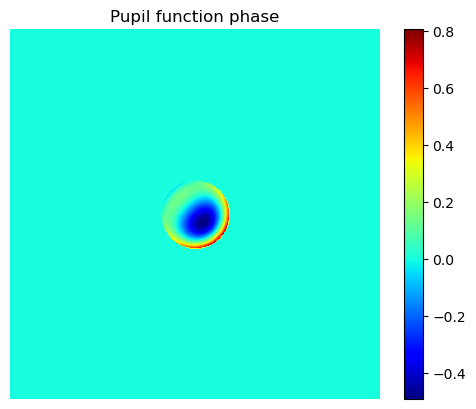

In [7]:
def zernike_polynomial(n, m, pupil):
    def polar_coords():
        """Generate polar coordinates for a given size"""
        x = np.linspace(-1, 1, cmax-cmin+1)
        y = np.linspace(-1, 1, rmax-rmin+1)
        X, Y = np.meshgrid(x, y)
        R = np.sqrt(X**2 + Y**2)
        T = np.arctan2(Y, X)
        T = np.where(T < 0, T + 2*np.pi, T)
        return R, T

    def radial_poly(n, m, R):
        """Calculate the radial polynomial"""
        radial = np.zeros_like(R)
        for s in range((n - abs(m)) // 2 + 1):
            coef = (-1)**s * np.math.factorial(n - s)
            coef /= np.math.factorial(s) * np.math.factorial((n + abs(m)) // 2 - s) * np.math.factorial((n - abs(m)) // 2 - s)
            radial += coef * R**(n - 2 * s)
        return radial

    rows = np.any(pupil, axis=1)
    cols = np.any(pupil, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]

    R, T = polar_coords()
    Radial = radial_poly(n, m, R)
    if m > 0:
        Z = np.sqrt(2*n+2) * Radial * np.cos(m * T)
    elif m < 0:
        Z = -np.sqrt(2*n+2) * Radial * np.sin(m * T)
    else:
        Z = np.sqrt(n+1) * Radial

    # Pad the Zernike polynomial to match the full pupil size
    padded_Z = np.zeros(pupil.shape)
    padded_Z[rmin:rmax+1, cmin:cmax+1] = Z
    return padded_Z

defocus_coef = 0.2
coma_coef = [0.1,0.1]
defocus = zernike_polynomial(2, 0, FILTER)
coma1 = zernike_polynomial(3, 1, FILTER)
coma2 = zernike_polynomial(3, -1, FILTER)
aberration = (defocus_coef*defocus+ coma_coef[0]*coma1 + coma_coef[1]*coma2)*FILTER
aberrated_FILTER = FILTER * np.exp(1j*aberration)

plt.imshow(np.angle(aberrated_FILTER), cmap='jet')
plt.title('Pupil function phase')
plt.axis('off')
plt.colorbar()
plt.show()


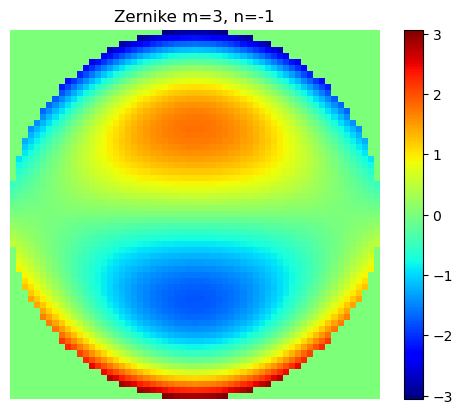

In [8]:
defocus_coef = 0
coma_coef = [0,1]
defocus = zernike_polynomial(2, 0, FILTER)
coma1 = zernike_polynomial(3, 1, FILTER)
coma2 = zernike_polynomial(3, -1, FILTER)
aberration = (defocus_coef*defocus+ coma_coef[0]*coma1 + coma_coef[1]*coma2)*FILTER

plt.imshow(aberration[136:197, 136:197], cmap='jet')
plt.title('Zernike m=3, n=-1')
plt.axis('off')
plt.colorbar()
plt.show()

# Generate aberrated FPM measurements

In [10]:
Sx = np.linspace(-1,1,9)
Sy = np.linspace(-1,1,9)
folder = './sim_data/'
for sx in Sx:
    for sy in Sy:
        X0 = round(sx*fc_lens*Dx_m)
        Y0 = round(sy*fc_lens*Dx_m)
        obj_angle = ift(aberrated_FILTER*circshift2(ft(obj_lines), -X0, -Y0))
        img_angle = np.abs(obj_angle)**2
        # scale by fixed exposure
        img_angle = img_angle / 8 * 255
        sx_str = str(sx).zfill(5)
        sy_str = str(sy).zfill(5)
        filename = f'aberrated_fineline_{sx_str}_data_{sy_str}.png'
        img_pil = Image.fromarray(np.uint8(img_angle))
        img_pil.save(f'{folder}/{filename}')

np.save('./sim_data/obj_fineline.npy', obj_lines)
np.save('./sim_data/pupil_function.npy', aberrated_FILTER)

# Generate anime object

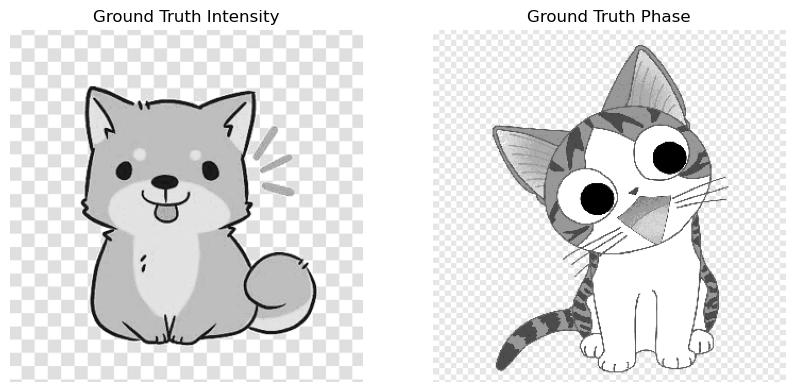

In [21]:
intensity = Image.open('intensity.png')
intensity = intensity.resize((roi_size_px, roi_size_px))
intensity = np.asarray(intensity.convert('L'))/255

phase = Image.open('phase.png')
phase = phase.resize((roi_size_px, roi_size_px))
phase = np.asarray(phase.convert('L'))/255*np.pi

obj_anime = intensity * np.exp(1j*phase)


# Create figure (fig), and array of axes (ax)
fig, ax = plt.subplots(1, 2, figsize=(10,5))

# Display the image
ax[0].imshow(np.abs(obj_anime), cmap='gray')
ax[1].imshow(np.angle(obj_anime), cmap='gray')

# Hide the axes
ax[0].axis('off')
ax[1].axis('off')

# Add titles
ax[0].set_title('Ground Truth Intensity')
ax[1].set_title('Ground Truth Phase')

# Show the plot
plt.show()


In [25]:
Sx = np.linspace(-1,1,9)
Sy = np.linspace(-1,1,9)
folder = './sim_anime'
for sx in Sx:
    for sy in Sy:
        X0 = round(sx*fc_lens*Dx_m)
        Y0 = round(sy*fc_lens*Dx_m)
        obj_angle = ift(aberrated_FILTER*circshift2(ft(obj_anime), -X0, -Y0))
        img_angle = np.abs(obj_angle)**2
        # scale by fixed exposure
        img_angle = img_angle / 3 * 255
        sx_str = str(sx).zfill(5)
        sy_str = str(sy).zfill(5)
        filename = f'aberrated_line_{sx_str}_data_{sy_str}.png'
        img_pil = Image.fromarray(np.uint8(img_angle))
        img_pil.save(f'{folder}/{filename}')

np.save('obj_anime.npy', obj_anime)
np.save('pupil_function.npy', aberrated_FILTER)